<img src='../img/EUMETSAT_Logo.png' alt='Logo EUMETSAT' align='right' width='30%'></img>

<a href="../00_index.ipynb"><< Index</a><br>

<div class="alert alert-block alert-success">
<b>60 - DATA CUBE</b></div>

<hr>

# Map and time-series analysis of Metop-A/B GOME-2 Tropospheric NO<sub>2</sub> Level 3 data with Data Tailor

This is a Python-based training module presenting how to use the **EUMETSAT Atmospheric Composition Data Cube** (ACDC) plugin for the **EUMETSAT Data Tailor** to work with satellite-derived geophysical variables relevant for atmospheric monitoring.

## Introduction

The **Data Tailor ACDC plugin** simplifies the process to manipulate data and thus visualise the datasets on maps.
Specifically, the plugin features the following functionalities:
* it downloads the desired data from the reference website
* it allows cropping a region of interest (ROI) 
* it allows defining a filter to save only the variables of interest (layer filter)
* it allows defining the time coverage of the dataset (accordigly to the available input data)
* it converts input products to NetCDF format compliant with CF-conventions and Climate Data Store ([CDS](https://cds.climate.copernicus.eu)) Common Data Model with coordinates dimensions
* it allows time aggregation returning a single dataset
* it estimates the output products size in advance.

This notebook presents an example similar to this [Atmospheric Composition Data notebook](https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/30_case_studies/321_air_pollution_map_time-series_Metop-AB_GOME-2_NO2Tropo_L3.ipynb) which focuses on
*GOME-2 Metop-A/B Level 3 Nitrogen Dioxide (NO2)* longterm monthly average data products. We will use the ACDC plugin for data retrieval and customisation.
Specifically, you will see examples of how to plot the `Nitrogen dioxide` variable time-series.

In this tutorial **you will learn how to use the following ACDC plugin features**:
* define the configuration to obtain the GOME-2 data from Metop-A/B satellites specifying
    * a time period for each product
    * a layer filter for *Nitrogen dioxide* variable
* estimate the output products size (data cube size)
* invoke the Data Tailor interface
* generate the output products in NetCDF format.

With the output products, you will:
* aggregate data to obtain a time-series
* visualise the monthly aggregates on a `2D Map`
* visualise time-series on selected locations
* save output products locally.

### Module outline:
* [1 - Obtain NO<sub>2</sub> data using the *Atmospheric Composition Data Cube* plugin](#Obtain-NO2-data-using-the-Atmospheric-Composition-Data-Cube-plugin)
* [2 - Combine data in a single output dataset](#Combine-data-in-a-single-output-dataset)
* [3 - Explore data with a 2D Map](#Explore-data-with-a-2D-Map)
* [4 - Explore time-series of tropospheric column NO<sub>2</sub> for specific locations](#Explore-time-series-of-tropospheric-column-NO2-for-specific-locations)
* [5 - Save the data cube locally](#Save-the-data-cube-locally)

<hr>

### Load required external libraries

In [1]:
import os
from pathlib import Path
import xarray as xr
    
from matplotlib import pyplot as plt

In [2]:
os.environ['PATH'] = f"/opt/conda/envs/acdc-training/bin/:{os.environ['PATH']}"

In [3]:
# Load auxiliary functions
%run ../functions.ipynb

## Obtain NO<sub>2</sub> data using the *Atmospheric Composition Data Cube* plugin

To use the functionalities of the ACDC plugin, you only need to import the **Data Tailor API**.

In [4]:
from epct import api

### Define the Data Tailor configuration

Let's use the *Data Tailor API interface* to obtain an *Atmospheric Composition Data Cube* containing the GOME-2 Level 3 Nitrogen Dioxide (NO2) from Metop-A and Metop-B satellites.

Furthermore, you will see how to estimate the output dataset size in advance.

Let's start selecting the products of interest for the Data Tailor interface.

#### Select the satelllite products

Define a "product_id" variable for each satellite data: 

In [5]:
# Input product for Data Cube
product_id_A = 'GOME2_METOPA_NO2'
product_id_B = 'GOME2_METOPB_NO2'

**Note**: to obtain the dictionary of supported products, see [0_Introduction_to_Data_Tailor_ACDC_plugin](0_Introduction_to_Data_Tailor_ACDC_plugin.ipynb)

#### Define the time coverage

You can select a time subset defining the following variables:
* *sensing_start*: a date equal to or later than the available "start-date"
* *sensing_stop*: a date earlier than or equal to the available "stop-date", if any

By default, if you don't specify a time period, the plugin automatically retrieves all the available time stamps from the reference web provider.

Dates must be defined in the following format: $$'<year><month><day>T000000Z'$$

Let's print the time coverage of the selected products using the Data Tailor API `config` function as follows:

In [6]:
# Discover the available temporal availability
config = api.config()
for product in [product_id_A, product_id_B]:
    product_specs = config['backends_configurations']['epct_acdc']['INPUT_PRODUCTS'][product]
    print(product)
    print("periodicity: {}".format(product_specs['periodicity']))
    print("start-date: {}".format(product_specs['start_date']))
    if 'end_date' in product_specs:
        print("stop-date: {}".format(product_specs['end_date']))
    print('\n')

GOME2_METOPA_NO2
periodicity: monthly
start-date: 20070201
stop-date: 20170831


GOME2_METOPB_NO2
periodicity: monthly
start-date: 20130101
stop-date: 20170831




As we want to obtain a different time period for the two satellites, we put the corresponding values in two lists. 

In [7]:
# sensing_start for both satellites
sensing_start = ['20070101T000000Z', '20130101T000000Z']
# sensing_stop for both satellites
sensing_stop = ['20121231T000000Z', '20170101T000000Z']

#### (Optional) Select the layer(s) of interest

Let's see the available layers for the selected products, using the *Data Tailor API* function `epct read`. As the three satellites acquire the same variables, explore the layer list only for the satellite `Metop-A`.

In [8]:
# Define a printing function for the selected product available layers  
def print_product_layers(dct, product_id):
    layers=dct['bands']
    print("{} layers: \n".format(product_id))
    for key, value in layers.items():  
         print("{}) {}: {}".format(value['number'], key, value['name']))
            
# Obtain the list of available layers             
products = api.read(f"products/{product_id_A}")
        
# Display the list calling the above printing function
print_product_layers(products, product_id_A)

GOME2_METOPA_NO2 layers: 

1) cloud_albedo: Average cloud albedo
2) cloud_albedo_std: Cloud albedo standard_deviation
3) cloud_fraction: Average cloud area fraction
4) cloud_fraction_std: Cloud area fraction standard deviation
5) cloud_height: Average cloud height
6) cloud_height_std: height at cloud top standard deviation
7) no2_total: Total Column NO2 content
8) no2_total_err: Error associated to total column NO2 content
9) no2_total_std: Total column NO2 standard deviation
10) no2_trop: Tropospheric column NO2 content
11) no2_trop_err: Error associated to tropospheric tolumn NO2 content
12) no2_trop_std: Tropospheric column NO2 standard deviation
13) nobs: Number of Observations
14) surface_albedo: Average surface area albedo
15) surface_flag: Average land sea flag
16) surface_height: Avearge surface area height [km]


As you can see, the product contains sixteen different variables. 

You can select one or more variables.

To select the *Tropospheric column NO2 content* (`no2_trop`), you need to specify such variable name in a dictionary having the key `bands` as follows:

In [9]:
# Input product layer selection
layer_filter = {'bands': ['no2_trop']}

**Note**: if you don't define a layer filter, by default the *Data Tailor interface* stores all the available variables in the output products.

### Estimate your Atmospheric Composition Data Cube size

The ACDC plugin API `estimate_cube_size` function gives you an estimate of the disk memory required to save the output dataset locally. It considers the data time coverage and if any ROI and/or layer filter selection is applied. Use `help(acdc.estimate_cube_size)` to see the function documentation. 

To use the `estimate_cube_size` function, you must first import the module `acdc` from the Data Tailor ACDC plugin.

Using the *Data Tailor API*, you can request one product per time.  Therefore, to obtain the overall size, we calculate each request apart and sum them together.

In [10]:
# Import the acdc module
from epct_plugin_acdc import acdc

In [11]:
# Estimate the data cube size for each satellite
cube_size_A = acdc.estimate_cube_size(product_id_A, sensing_start[0], sensing_stop[0], band_filter=layer_filter)
cube_size_B = acdc.estimate_cube_size(product_id_B, sensing_start[1], sensing_stop[1], band_filter=layer_filter)

# Sum the two values to obtain the total size
cube_size = cube_size_A + cube_size_B

# Print the obtained value
print('Data Cube size = {:5.3f} Mb.'.format(cube_size))

Data Cube size = 1601.737 Mb.


### Generate your Atmospheric Composition Data Cube

To retrieve and customise the two different products, you have to invoke the *Data Tailor API* `run_chain` function two times (one for each satellite data). 

This action will: 
* download the data from the reference web site
* convert it in a CF-compliant homogenised NetCDF format files
* return the paths to the output files

To invoke the `run_chain` you need to specify:
* an input file
* a directory to store the outputs
* the customisation configuration, including the layer filter
* the start-date and end-date of the period of interest

We don't need real a input file because the data are automatically retrieved from the provider. So, let's start creating a dummy file. 

In [12]:
# Create a dummy file
Path('dummy.txt').touch()
product_paths = ['dummy.txt']

Let's define the output path:

In [13]:
# Define the output path
target_dir='.'

Now, you need to define the configuration as a dictionary. 
For this example, the dictionary must have the following keys:
* *product* (mandatory) 
* *format* (mandatory): use "*netcdf4_acdc*" to specify the conversion to NetCDF obedient to CF-convention
* *aggregation* (optional): if you want the output to be a single dataset containing all time-stamps
* *filter* (optional): to filter only the Tropospheric column NO<sub>2</sub> content variable

To retrieve two different products, let's define the dictionary and invoke the customisation function in a `for loop`.


**Note**: If you are interested in a region subset, you can add the `"roi"` keyword in the `chain_config` dictionary. To have details on how to obtain a geographical region of interest explore the [0_Introduction_to_Data_Tailor_ACDC_plugin](0_Introduction_to_Data_Tailor_ACDC_plugin.ipynb) notebook.

In [14]:
output_products = []
i=0

for product in [product_id_A, product_id_B]:
    
    # Define the chain_config dictionary with the current product_id
    chain_config = {
        "product": product,
        "format": "netcdf4_acdc",
        "aggregation": "time",
        "filter": layer_filter,
    }
    
    # Invoke run_chain function 
    output_paths = api.run_chain(
        product_paths, 
        chain_config=chain_config, 
        target_dir=target_dir, 
        sensing_start=sensing_start[i],
        sensing_stop=sensing_stop[i]
    )
    
    i=+1
    
    output_products.extend(output_paths)

2022-02-09 16:07:19 - PROCESSING.chain_runner[270] - INFO - Start process "f154ad17"
2022-02-09 16:07:19 - PROCESSING.chain_runner[231] - INFO - WORKER: localhost
2022-02-09 16:07:19 - PROCESSING.chain_runner[232] - INFO - PID: 14836
2022-02-09 16:07:19 - PROCESSING.chain_runner[233] - INFO - backend: epct_acdc
2022-02-09 16:07:19 - PROCESSING.chain_runner[234] - INFO - user: None
2022-02-09 16:07:20 - PROCESSING.preprocessing[523] - INFO - Processing details - product: GOME2_METOPA_NO2 chain-name: None chain-details: -product: GOME2_METOPA_NO2 -format: NetCDF4 (ACDC Satellite Data Cube) -aggregation: Time -filter: Custom -sensing-start: 20070101T000000Z -sensing-stop: 20121231T000000Z
2022-02-09 16:07:20 - PROCESSING.preprocessing[530] - INFO - Input products: dummy.txt


product: GOME2_METOPA_NO2
chain-name: None
chain-details:
-product: GOME2_METOPA_NO2
-format: NetCDF4 (ACDC Satellite Data Cube)
-aggregation: Time
-filter: Custom
-sensing-start: 20070101T000000Z
-sensing-stop: 20121231T000000Z

[ 0/71]📥📥📥📥📥📥📥📥📥📥[10]

[10/71]📥📥📥📥📥📥📥📥📥📥[20]

[20/71]📥📥📥📥📥📥📥📥📥📥[30]

[30/71]📥📥📥📥📥📥📥📥📥📥[40]

[40/71]📥📥📥📥📥📥📥📥📥📥[50]

[50/71]📥📥📥📥📥📥📥📥📥📥[60]

[60/71]📥📥📥📥📥📥📥📥📥📥[70]

[70/71]📥 [71/71] *DONE*
status: DONE


2022-02-09 16:12:10 - PROCESSING.postprocessing[503] - INFO - output-product: ./GOME2_METOPA_NO2_20070201_20121231_acdc.nc



output-products: ./GOME2_METOPA_NO2_20070201_20121231_acdc.nc


2022-02-09 16:12:10 - PROCESSING.postprocessing[514] - INFO - customisation time: 291 - process: f154ad17
2022-02-09 16:12:10 - PROCESSING.postprocessing[515] - INFO - *** STOP PROCESSING - Status DONE ***
2022-02-09 16:12:10 - PROCESSING.chain_runner[270] - INFO - Start process "e7f49232"
2022-02-09 16:12:10 - PROCESSING.chain_runner[231] - INFO - WORKER: localhost
2022-02-09 16:12:10 - PROCESSING.chain_runner[232] - INFO - PID: 14836
2022-02-09 16:12:10 - PROCESSING.chain_runner[233] - INFO - backend: epct_acdc
2022-02-09 16:12:10 - PROCESSING.chain_runner[234] - INFO - user: None
2022-02-09 16:12:11 - PROCESSING.preprocessing[523] - INFO - Processing details - product: GOME2_METOPB_NO2 chain-name: None chain-details: -product: GOME2_METOPB_NO2 -format: NetCDF4 (ACDC Satellite Data Cube) -aggregation: Time -filter: Custom -sensing-start: 20130101T000000Z -sensing-stop: 20170101T000000Z
2022-02-09 16:12:11 - PROCESSING.preprocessing[530] - INFO - Input products: dummy.txt


product: GOME2_METOPB_NO2
chain-name: None
chain-details:
-product: GOME2_METOPB_NO2
-format: NetCDF4 (ACDC Satellite Data Cube)
-aggregation: Time
-filter: Custom
-sensing-start: 20130101T000000Z
-sensing-stop: 20170101T000000Z

[ 0/49]📥📥📥📥📥📥📥📥📥📥[10]

[10/49]📥📥📥📥📥📥📥📥📥📥[20]

[20/49]📥📥📥📥📥📥📥📥📥📥[30]

[30/49]📥📥📥📥📥📥📥📥📥📥[40]

[40/49]📥📥📥📥📥📥📥📥📥 [49/49] *DONE*
status: DONE


2022-02-09 16:16:14 - PROCESSING.postprocessing[503] - INFO - output-product: ./GOME2_METOPB_NO2_20130101_20170131_acdc.nc



output-products: ./GOME2_METOPB_NO2_20130101_20170131_acdc.nc


2022-02-09 16:16:14 - PROCESSING.postprocessing[514] - INFO - customisation time: 244 - process: e7f49232
2022-02-09 16:16:14 - PROCESSING.postprocessing[515] - INFO - *** STOP PROCESSING - Status DONE ***


The variable `output_products` is a list containing the output dataset paths of the Data Tailor customisations. In the following, you can use the `output_products` variable to load the obtained dataset.

Let's visualise it:

In [15]:
output_products

['./GOME2_METOPA_NO2_20070201_20121231_acdc.nc',
 './GOME2_METOPB_NO2_20130101_20170131_acdc.nc']

As you can see, the output consists of two NetCDF files containing all the required time-stamp (one for each satellite).

**Note**: in the customisation process, data is automatically converted to the `International System of units` (SI). Therefore, `no2tmc` is converted from `1e13 molec cm-2` to `mol m-2`.

## Combine data in a single output dataset

To incorporate different Atmospheric Composition products in a single dataset, load the GOME-2 Levels Nitrogen dioxide (NO<sub>2</sub>) data with the xarray's library function `xr.open_mfdataset` specifying the dimension to be concatenated, i.e. `time`. 

The resulting object is a three-dimensional dataset with the dimensions `latitude`, `longitude` and `time` having coordinates assigned. The dataset contains only the `no2_trop` data physical variable and is CF-compliant.

In [16]:
aggregate_data = xr.open_mfdataset(output_products, concat_dim='time')
aggregate_data

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 120)
Coordinates:
  * time     (time) datetime64[ns] 2007-02-01 2007-03-01 ... 2017-01-01
  * lon      (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
Data variables:
    no2tmc   (time, lat, lon) float32 dask.array<chunksize=(71, 720, 1440), meta=np.ndarray>
    crs      (time) int32 dask.array<chunksize=(71,), meta=np.ndarray>
Attributes:
    CDI:                                       Climate Data Interface version...
    institution:                               DLR Deutsches Zentrum fuer Luf...
    Conventions:                               CF-1.8
    description:                               Level 3 NO2 data
    composite_type:                            1_month
    base_product:                              Level2 GDP
    base_product_version:                      v 4.8
    product_algorithm_name:                    NO2 O3MSAF
    product_format_type:                       netCDF
    product_format_version:                    4
    sensor:                                    GOME_2
    reference:                                 https://acsaf.org/datarecord_a...
    creator_name:                              Pieter Valks
    creator_email:                             Pieter.Valks@dlr.de
    processing_time:                           2017-12-13T10:53:34
    product_algorithm_version:                 v1
    projects:                                  ACSAF
    product_content:                           L3_NO2, L3_NO2Tropo, Cloud Par...
    geospatial_latitude_resolution:            0.25
    geospatial_latitude_units:                 Degrees_North
    geospatial_longitude_resolution:           0.25
    geospatial_longitude_units:                Degrees_East
    platform:                                  METOP-A
    time_coverage_start:                       20070201
    time_coverage_end:                         20121231
    filename:                                  GOME_NO2_Global_200702_METOPA_...
    product_ID:                                O3M-87
    DOI:                                       10.15770/EUM_SAF_O3M_0020
    CDO:                                       Climate Data Operators version...
    geospatial_lat_min:                        -90.0
    geospatial_lat_max:                        90.0
    geospatial_lon_min:                        -180.0
    geospatial_lon_max:                        180.0
    history:                                   2022-02-09 16:11:02: api.run_c...
    datacube_software_version:                 0.3.0
    doi:                                       10.15770/EUM_SAF_O3M_0020
    algorithm_theoretical_basis_document_url:  https://acsaf.org/docs/atbd/Al...
    product_user_manual_url:                   https://acsaf.org/docs/atbd/Al...
    validation_report_url:                     https://acsaf.org/docs/vr/Vali...
    product_url:                               https://acsaf.org/datarecords/...
    provider_name:                             Pieter Valks
    provider_email:                            Pieter.Valks@dlr.de
    provider_url:                              NA
    start_time:                                01-02-2007
    end_time:                                  31-08-2017
    product_version:                           NA

Let's select the `no2tmc` `xarray.DataArray` which corresponds to the `Tropospheric Column NO2 content`.

In [17]:
# Select a data variable for your plot
no2tmc = aggregate_data.no2tmc
no2tmc

<xarray.DataArray 'no2tmc' (time: 120, lat: 720, lon: 1440)>
dask.array<concatenate, shape=(120, 720, 1440), dtype=float32, chunksize=(71, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2007-02-01 2007-03-01 ... 2017-01-01
  * lon      (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
Attributes:
    cell_method:          time: mean (interval: 1 month) area: weighted-average
    units:                mol m-2
    ancillary_variables:  no2tmc_error no2tmc_stddev nobs
    standard_name:        troposphere_mole_content_of_nitrogen_dioxide
    long_name:            tropospheric column NO2 content
    grid_mapping:         crs

## Explore data with a `2D Map`

A first step to explore the data is to create a simple `2D Map`. You can make use of the function [visualize_pcolormesh](utils.ipynb#visualize_pcolormesh) which takes the following arguments:
* `data_array`
* `longitude`
* `latitude`
* `projection`
* `color_scale`
* `unit`
* `long_name`
* `vmin`
* `vmax`

Specify a `month` and visualize the tropospheric NO<sub>2</sub> column content of the selcted period.

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f5977273400>)

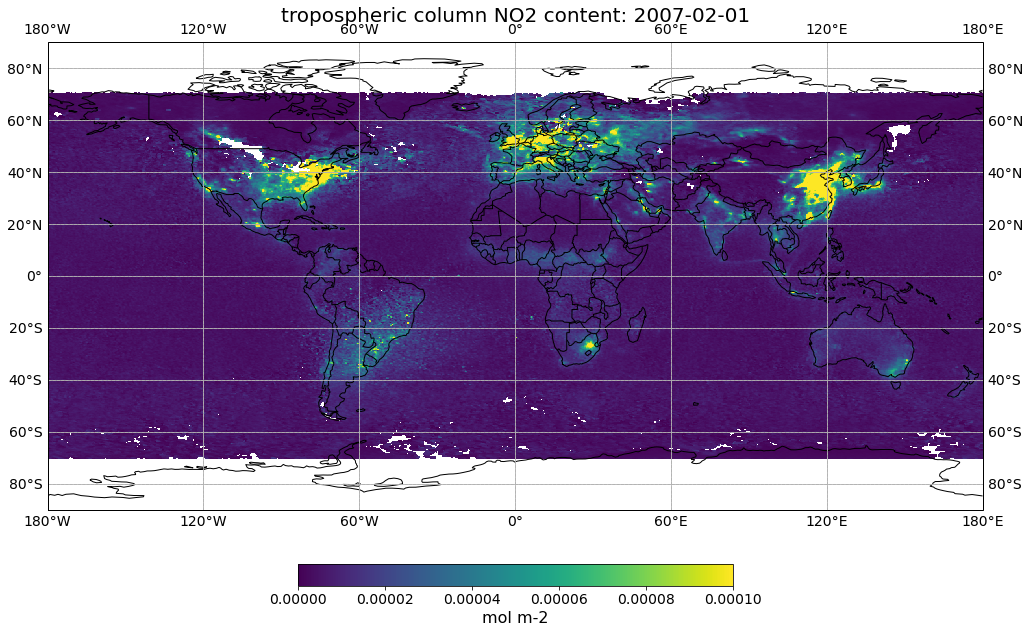

In [18]:
month=0
visualize_pcolormesh(data_array=no2tmc.isel(time=month),
                     longitude=no2tmc.lon,
                     latitude=no2tmc.lat,
                     projection=ccrs.PlateCarree(),
                     color_scale='viridis',
                     unit=no2tmc.units,
                     long_name=no2tmc.long_name + ': ' + str(no2tmc.time[month].dt.strftime('%Y-%m-%d').data),
                     vmin=0,
                     vmax=1e-04)

## Explore time-series of tropospheric column NO<sub>2</sub> for specific locations

Let us have a look at the time-series for individual point locations.

We want to compare an European city, `Darmstadt`, with `Beijing` region where there is a prominent increase of the tropospheric column of nitrogen dioxide parameter.

We specify latitude and longitude coordinates for both cities and plot the two `xarray.DataArrays` as line plots using the plotting wrapper of Python's matplotlib.
Using xarray's label based selection method `sel` we select data based on name or value.

In [19]:
# Latitude / Longitude coordinates for Darmstadt
city1 = 'Darmstadt'
lat1 = 49.875
lon1 = 8.650

# Latitude / Longitude coordinates for Beijing
city2 = 'Beijing'
lat2 = 39.908
lon2 = 116.397

Let's have a look at the time-series for individual point locations. 

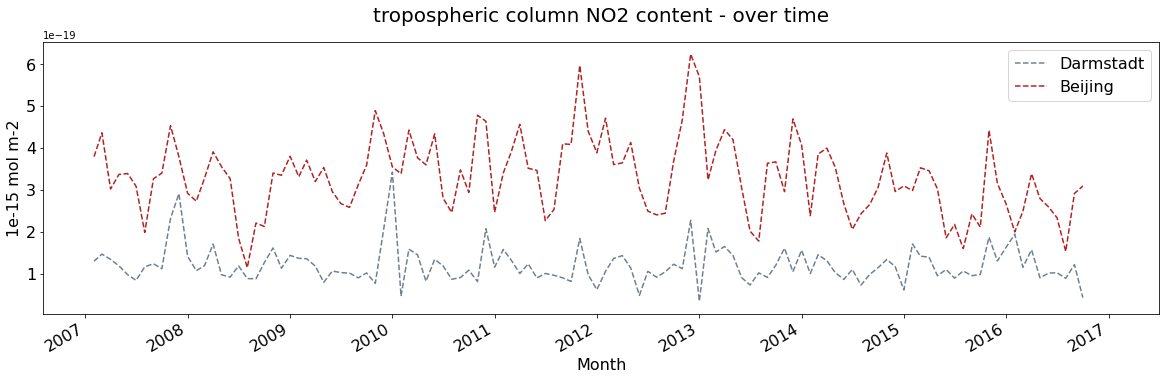

In [20]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig = plt.figure(figsize=(20,5))
conversion_factor = 1e-15

city1_total = no2tmc.sel(lat=lat1, lon=lon1, method='nearest')*conversion_factor
city1_total.plot.line(color='slategrey', linestyle='dashed', label=city1)

city2_total = no2tmc.sel(lat=lat2, lon=lon2, method='nearest')*conversion_factor
city2_total.plot.line(linestyle='dashed',color='firebrick', label=city2)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(no2tmc.long_name + " - over time", fontsize=20, pad=20)
plt.ylabel(str(conversion_factor) + ' ' + no2tmc.units, fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.legend(fontsize=16,loc=1)
plt.show()

The plot above shows that the NO<sub>2</sub> levels in Beijing are in general higher than the levels in Darmstadt.

There is a prominent spike of tropospheric NO<sub>2</sub> levels in Beijing in January 2013, which reflects the [Heavy haze pollution episode over central and western China](https://link.springer.com/article/10.1007/s11430-013-4773-4).

## Save the data cube locally

You can download the data cube locally by executing the following cell.

In [21]:
download_file = './NO2_data.nc'
print ('Saving to: ', download_file)

aggregate_data.to_netcdf(path=download_file)
print ('Data saved on disk!')

Saving to:  ./NO2_data.nc
Data saved on disk!


## Remove all files from the target directory

To clean-up the target directory at the end of the notebook, you just need to execute the cell below.

In [22]:
files_to_remove = os.listdir(target_dir)

for file in files_to_remove:
    if file.endswith(".nc") or file.endswith(".txt"):
        os.remove(os.path.join(target_dir, file))
print(os.listdir(target_dir))

['1_Multivariable_datacube_for_atmospheric_composition_observation.ipynb', '2_Multiproduct_datacube_for_atmospheric_composition_observation.ipynb', '0_Introduction_to_Data_Tailor_ACDC_plugin.ipynb', '3_Multiplatform_datacube_for_atmospheric_composition_observation.ipynb', '4_Multisensor_multiplatform_datacube_for_atmospheric_composition_observation.ipynb', '.ipynb_checkpoints']


<br>

<a href="Index.ipynb"><< Index</a><br>

<p><img src='../img/EUMETSAT_Logo.png' align='left' alt='Logo EUMETSAT' width='15%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a> | 
<span style="float:right;"><a href="https://gitlab.eumetsat.int/data-tailor/acdc-notebooks">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a></p>